In [1]:
import torch
from torch import nn
import cv2
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tqdm
from torchvision import datasets, transforms
import wandb
from torch.utils.data import DataLoader
from sklearn.preprocessing import Normalizer

In [2]:
df = pd.read_csv('../raisins/Raisin_Dataset.csv')

In [3]:
len(df)

900

In [4]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [5]:
# df.drop(columns=['Id'], inplace=True)

In [6]:
label_encoder = LabelEncoder()

In [7]:
df['Class'] = label_encoder.fit_transform(df['Class'])
# df['Species'] = label_encoder.fit_transform(df['Species'])

In [8]:
X = torch.from_numpy(df.iloc[:450, :df.shape[1] -1].to_numpy())
Y = torch.from_numpy(df.iloc[:450, df.shape[1] -1].to_numpy())

In [9]:
normalizer = Normalizer()
X = torch.from_numpy(normalizer.fit_transform(X))

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.fc(x)


class Generator(nn.Module):

    def __init__(self, z_dim, output_dim):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(z_dim, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=output_dim),
        )

    def forward(self, x):
        x = self.generator(x)
        return x
        

In [11]:
feature_vector_len = 7
z_dim = 100

dn = Discriminator(input_dim=feature_vector_len)
gn = Generator(z_dim=z_dim, output_dim=feature_vector_len)

In [12]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(dn.parameters(), lr=6e-4)
g_optimizer = torch.optim.Adam(gn.parameters(), lr=6e-4)

In [13]:
random_data = torch.rand(X.shape[0], z_dim)



truth_labels = torch.ones_like(random_data[:, 0])
fake_labels = torch.zeros_like(random_data[:, 0])

In [14]:
real_data = X.float()

real_data.shape


torch.Size([450, 7])

## Training the GAN without any freezing of the discriminator

In [15]:
# 2000 epochs used since it was observed that the nash convergence occurred at around 2000 epochs
epochs = 2000

for _ in range(epochs):

    # if _ < 5000:
    d_optimizer.zero_grad()
    
    outputs = dn(real_data).view(-1)
    d_loss_truth = loss_fn(outputs, truth_labels)
    
    random_data = torch.rand(X.shape[0], z_dim)
    fake_data = gn(random_data).float()
    outputs = dn(fake_data).view(-1)
    d_loss_fake = loss_fn(outputs, fake_labels)
    
    d_loss = d_loss_truth + d_loss_fake
    
    d_loss.backward()
    d_optimizer.step()
        
    # training generator
    g_optimizer.zero_grad()
    random_data = torch.rand(X.shape[0], z_dim)
    fake_data = gn(random_data).float()
    
    outputs = dn(fake_data).view(-1)
    g_loss = loss_fn(outputs, truth_labels)
    g_loss.backward()
    g_optimizer.step()

    print(f'Epoch {_ + 1} ; g_loss {g_loss} ; d_loss {d_loss} ')





Epoch 1 ; g_loss 0.6700785160064697 ; d_loss 1.3897836208343506 
Epoch 2 ; g_loss 0.676082193851471 ; d_loss 1.3646835088729858 
Epoch 3 ; g_loss 0.681603729724884 ; d_loss 1.3430122137069702 
Epoch 4 ; g_loss 0.6867004632949829 ; d_loss 1.3247685432434082 
Epoch 5 ; g_loss 0.6892803907394409 ; d_loss 1.3085658550262451 
Epoch 6 ; g_loss 0.6904268264770508 ; d_loss 1.2951076030731201 
Epoch 7 ; g_loss 0.6893216967582703 ; d_loss 1.284635066986084 
Epoch 8 ; g_loss 0.6846177577972412 ; d_loss 1.2776894569396973 
Epoch 9 ; g_loss 0.6757632493972778 ; d_loss 1.2758476734161377 
Epoch 10 ; g_loss 0.6627640128135681 ; d_loss 1.2792776823043823 
Epoch 11 ; g_loss 0.6419637203216553 ; d_loss 1.2903138399124146 
Epoch 12 ; g_loss 0.6154414415359497 ; d_loss 1.3130486011505127 
Epoch 13 ; g_loss 0.5856620073318481 ; d_loss 1.342728614807129 
Epoch 14 ; g_loss 0.552322506904602 ; d_loss 1.3827767372131348 
Epoch 15 ; g_loss 0.5213884711265564 ; d_loss 1.4285166263580322 
Epoch 16 ; g_loss 0.4865

In [16]:
generated_data = gn(random_data)

## Plotting the 7 features one at a time (blue -> generated, red -> actual data)
#### Note: the distance between the blue and the red regions should be the least for a good copy of the distribution
### As you can see, once nash eq. is achieved, the red and blue regions stop coming close to one another since the generator is not able to get better at defeating the discriminator.

### Hence, we freeze the discriminator in the following code cells, to allow the generator to get better at generating fake samples.

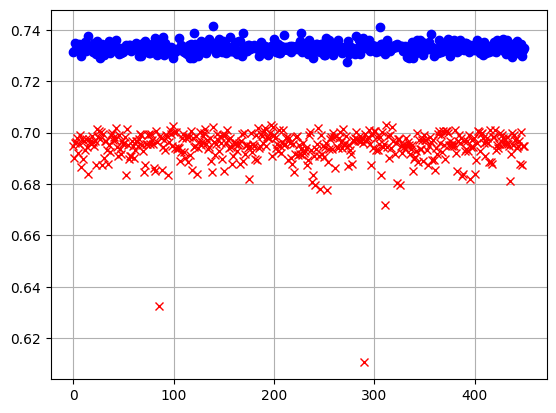

In [17]:
plt.grid()
plt.plot(generated_data[:, 0].detach().numpy(), 'bo')
plt.plot(X[:, 0].detach().numpy(), 'rx')

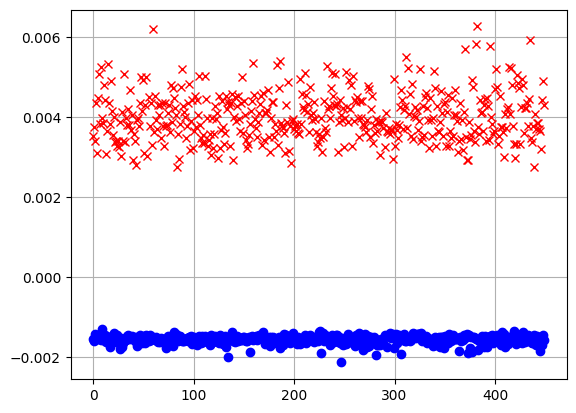

In [18]:
plt.grid()
plt.plot(generated_data[:, 1].detach().numpy(), 'bo')
plt.plot(X[:, 1].detach().numpy(), 'rx')

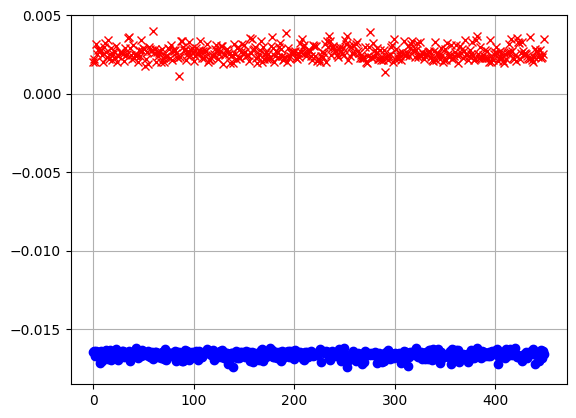

In [19]:
plt.grid()
plt.plot(generated_data[:, 2].detach().numpy(), 'bo')
plt.plot(X[:, 2].detach().numpy(), 'rx')

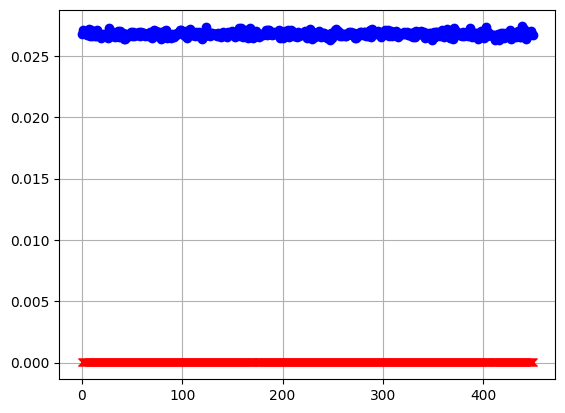

In [20]:
plt.grid()
plt.plot(generated_data[:, 3].detach().numpy(), 'bo')
plt.plot(X[:, 3].detach().numpy(), 'rx')

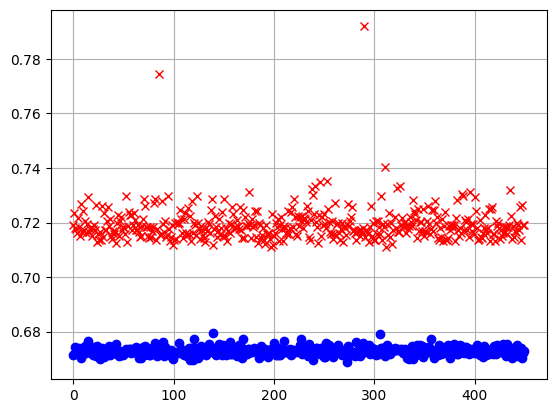

In [21]:
plt.grid()
plt.plot(generated_data[:, 4].detach().numpy(), 'bo')
plt.plot(X[:, 4].detach().numpy(), 'rx')

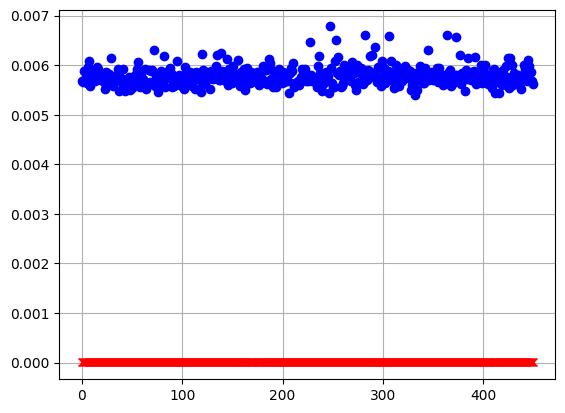

In [22]:
plt.grid()
plt.plot(generated_data[:, 5].detach().numpy(), 'bo')
plt.plot(X[:, 5].detach().numpy(), 'rx')

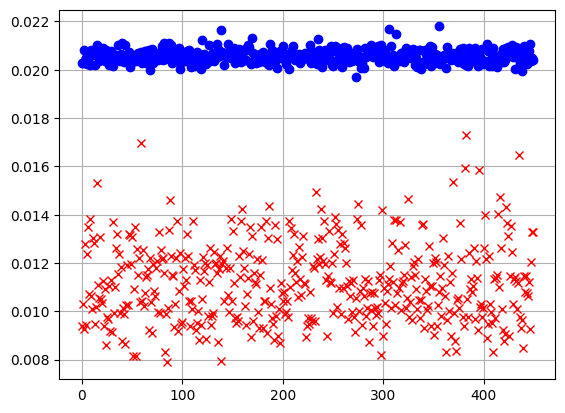

In [23]:
plt.grid()
plt.plot(generated_data[:, 6].detach().numpy(), 'bo')
plt.plot(X[:, 6].detach().numpy(), 'rx')

## Training the GAN and freezing the discriminator after 5000 epochs (once nash eq. has been reached)
### This allows the generator to get better at generating fake samples, since the discriminator training has been stopped; i.e the discriminator is not being allowed to get better

In [24]:
epochs = 20000

for _ in range(epochs):

    if _ < 5000:
        d_optimizer.zero_grad()
        
        outputs = dn(real_data).view(-1)
        d_loss_truth = loss_fn(outputs, truth_labels)
        
        random_data = torch.rand(X.shape[0], z_dim)
        fake_data = gn(random_data).float()
        outputs = dn(fake_data).view(-1)
        d_loss_fake = loss_fn(outputs, fake_labels)
        
        d_loss = d_loss_truth + d_loss_fake
        
        d_loss.backward()
        d_optimizer.step()
        
    # training generator
    g_optimizer.zero_grad()
    random_data = torch.rand(X.shape[0], z_dim)
    fake_data = gn(random_data).float()
    
    outputs = dn(fake_data).view(-1)
    g_loss = loss_fn(outputs, truth_labels)
    g_loss.backward()
    g_optimizer.step()

    print(f'Epoch {_ + 1} ; g_loss {g_loss} ; d_loss {d_loss} ')





Epoch 1 ; g_loss 0.6767563223838806 ; d_loss 1.4428482055664062 
Epoch 2 ; g_loss 0.6854503154754639 ; d_loss 1.436149001121521 
Epoch 3 ; g_loss 0.6913421154022217 ; d_loss 1.4286202192306519 
Epoch 4 ; g_loss 0.6945479512214661 ; d_loss 1.4204907417297363 
Epoch 5 ; g_loss 0.6958075165748596 ; d_loss 1.4128828048706055 
Epoch 6 ; g_loss 0.694678008556366 ; d_loss 1.4067319631576538 
Epoch 7 ; g_loss 0.6942251920700073 ; d_loss 1.399518609046936 
Epoch 8 ; g_loss 0.6976576447486877 ; d_loss 1.388597846031189 
Epoch 9 ; g_loss 0.7007043361663818 ; d_loss 1.3786299228668213 
Epoch 10 ; g_loss 0.7052692174911499 ; d_loss 1.367459774017334 
Epoch 11 ; g_loss 0.7154597043991089 ; d_loss 1.3518109321594238 
Epoch 12 ; g_loss 0.726340651512146 ; d_loss 1.3365800380706787 
Epoch 13 ; g_loss 0.7362282276153564 ; d_loss 1.3231472969055176 
Epoch 14 ; g_loss 0.7432773113250732 ; d_loss 1.3134026527404785 
Epoch 15 ; g_loss 0.7473779320716858 ; d_loss 1.3067430257797241 
Epoch 16 ; g_loss 0.74842

### The below cells demonstrate that the red and blue regions are much close to each other (overlap in many cases), which denotes that the generator is being able to generate much better fake samples. This is due to freezing the discriminator at 5k epochs and letting the generator train for the remaining 15k epochs.

In [25]:
generated_data = gn(random_data)

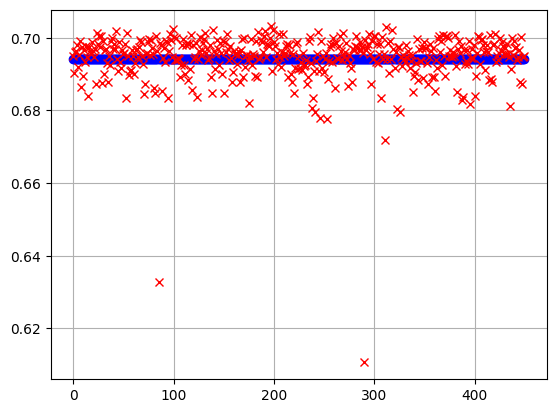

In [26]:
plt.grid()
plt.plot(generated_data[:, 0].detach().numpy(), 'bo')
plt.plot(X[:, 0].detach().numpy(), 'rx')

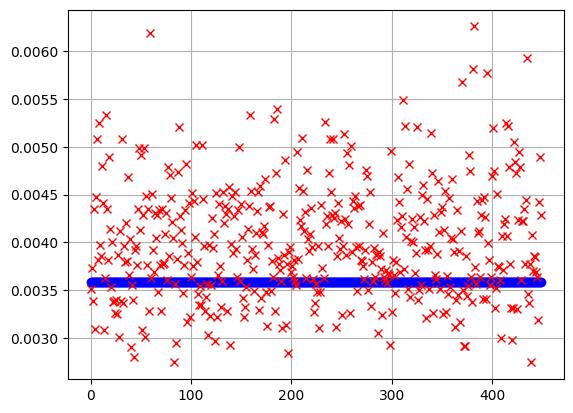

In [27]:
plt.grid()
plt.plot(generated_data[:, 1].detach().numpy(), 'bo')
plt.plot(X[:, 1].detach().numpy(), 'rx')

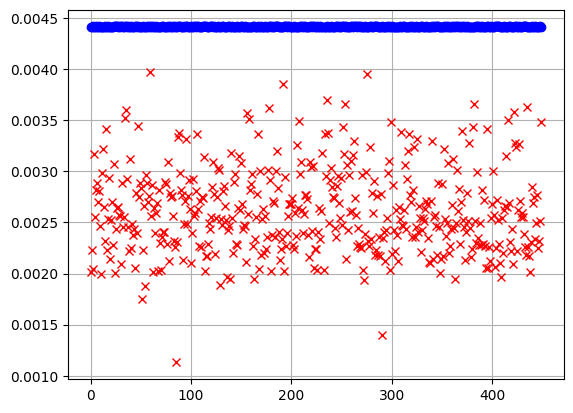

In [28]:
plt.grid()
plt.plot(generated_data[:, 2].detach().numpy(), 'bo')
plt.plot(X[:, 2].detach().numpy(), 'rx')

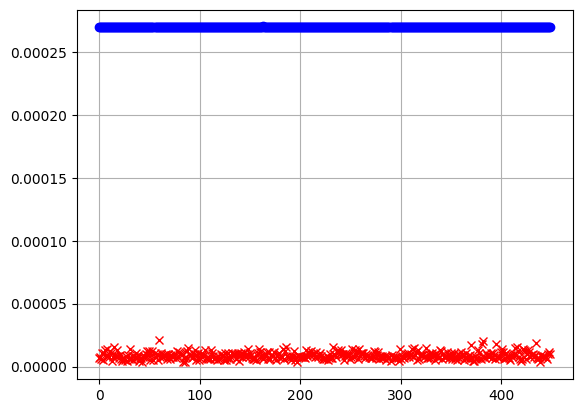

In [29]:
plt.grid()
plt.plot(generated_data[:, 3].detach().numpy(), 'bo')
plt.plot(X[:, 3].detach().numpy(), 'rx')

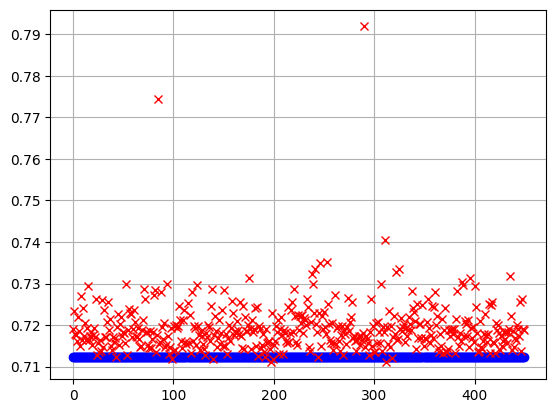

In [30]:
plt.grid()
plt.plot(generated_data[:, 4].detach().numpy(), 'bo')
plt.plot(X[:, 4].detach().numpy(), 'rx')

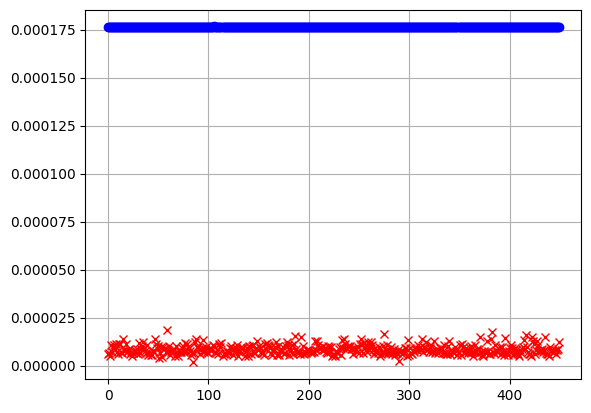

In [31]:
plt.grid()
plt.plot(generated_data[:, 5].detach().numpy(), 'bo')
plt.plot(X[:, 5].detach().numpy(), 'rx')

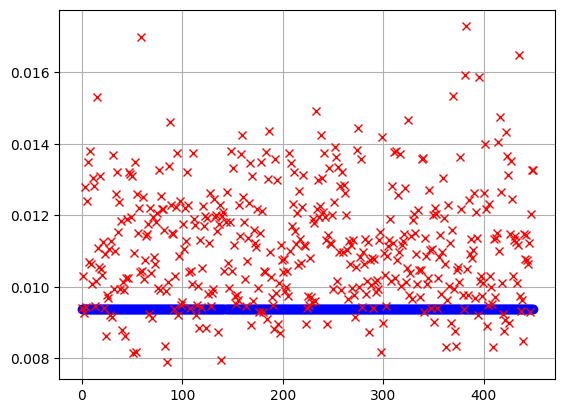

In [32]:
plt.grid()
plt.plot(generated_data[:, 6].detach().numpy(), 'bo')
plt.plot(X[:, 6].detach().numpy(), 'rx')